In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from torchsummary import summary

import numpy as np
import matplotlib.pyplot as plt

%load_ext autoreload
%autoreload 2

### One to Many function

In [2]:
n_samples = 1000

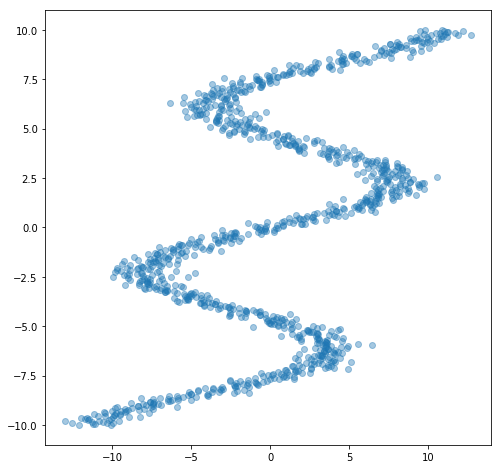

In [13]:
epsilon = torch.randn(n_samples)
x_data = torch.linspace(-10, 10, n_samples)
y_data = 7*np.sin(0.75*x_data) + 0.5*x_data + epsilon

y_data, x_data = x_data.view(-1, 1), y_data.view(-1, 1)

plt.figure(figsize=(8, 8))
plt.scatter(x_data, y_data, alpha=0.4)
plt.show()

In [29]:
n_input = 1
n_hidden = 20
n_output = 1

model = nn.Sequential(nn.Linear(n_input, n_hidden),
                        nn.Tanh(),
                        nn.Linear(n_hidden, n_output))

loss_fn = nn.MSELoss()

optimizer = torch.optim.RMSprop(model.parameters())

In [30]:
for epoch in range(3000):
    y_pred = model(x_data) 
    loss = loss_fn(y_pred, y_data) 
    optimizer.zero_grad() 
    loss.backward() 
    optimizer.step() 
    if epoch % 1000 == 0:
        print(loss.data.tolist())

37.464454650878906
21.90484046936035
21.841203689575195


In [31]:
x_test = torch.linspace(-15, 15, n_samples).view(-1, 1)
y_pred = model(x_test).data

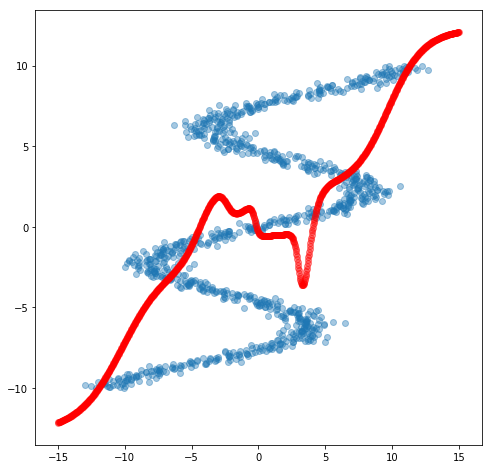

In [32]:
plt.figure(figsize=(8, 8))
plt.scatter(x_data, y_data, alpha=0.4)
plt.scatter(x_test, y_pred, alpha=0.4, color='red')
plt.show()

### Mixture Density Networks

In [55]:
class MDN(nn.Module):
    def __init__(self, n_hidden, n_gaussians):
        super(MDN, self).__init__()
        self.z_h = nn.Sequential(
            nn.Linear(1, n_hidden),
            nn.Tanh()
        )
        self.z_pi = nn.Linear(n_hidden, n_gaussians)
        self.z_mu = nn.Linear(n_hidden, n_gaussians)
        self.z_sigma = nn.Linear(n_hidden, n_gaussians)
    
    def forward(self, x):
        z_h = self.z_h(x)
        pi = F.softmax(self.z_pi(z_h), -1)
        mu = self.z_mu(z_h)
        sigma = torch.exp(self.z_sigma(z_h))
        return pi, mu, sigma

model = MDN(n_hidden=20, n_gaussians=5)

optimizer = torch.optim.Adam(model.parameters())

In [56]:
def mdn_loss_fn(y, mu, sigma, pi):
    m = torch.distributions.Normal(loc=mu, scale=sigma)
    loss = torch.exp(m.log_prob(y))
    loss = torch.sum(loss * pi, dim=1)
    loss = -torch.log(loss)
    return torch.mean(loss)

In [57]:
for epoch in range(10000):
    pi, mu, sigma = model(x_data)
    loss = mdn_loss_fn(y_data, mu, sigma, pi)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    if epoch % 1000 == 0:
        print(loss.data.tolist())

8.79819107055664
2.86043643951416
2.5497093200683594
2.01938533782959
1.8826366662979126
1.8235622644424438
1.628385066986084
1.5229711532592773
1.450204610824585
1.429850459098816


In [92]:
pi, mu, sigma = model(x_test)

In [93]:
k = torch.multinomial(pi, 1).view(-1)
y_pred = torch.normal(mu, sigma)[np.arange(n_samples), k].data

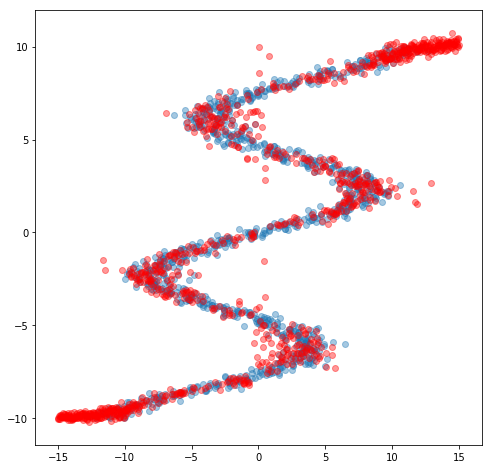

In [94]:
plt.figure(figsize=(8, 8))
plt.scatter(x_data, y_data, alpha=0.4)
plt.scatter(x_test, y_pred, alpha=0.4, color='red')
plt.show()